## **Modeling Hypotheses & Plan**

**Context**:
The Exploratory Data Analysis (EDA) phase identified key drivers of churn, high-risk customer segments, and redundant variables. This step outlines the modeling hypotheses, selected features, model candidates, and evaluation approach to ensure the modeling process is aligned with both statistical rigor and business objectives.

**Features to Keep**

We will include variables that showed strong association with churn in the EDA and that are not mathematically redundant:
* Customer tenure (tenure) – strongest negative correlation with churn.
* Contract (encoded) – clear separation between Month-to-month vs longer-term.
* InternetService (encoded) – Fiber optic associated with higher churn rates.
* PaymentMethod (encoded) – Electronic check linked to elevated churn risk.
* SeniorCitizen, Partner, Dependents – demographic factors influencing churn.
* OnlineSecurity, TechSupport – protection services correlated with retention.
* PaperlessBilling – linked to higher churn likelihood.
* Streaming services – optional inclusion to assess incremental value.

**Features to Drop**
* TotalCharges, TotalRevenue, AverageCharges – mathematically redundant with tenure × MonthlyCharges (confirmed by VIF).
* One of PhoneService or MultipleLines may be removed if it provides low incremental gain in modeling.

**Interaction Terms to Consider**

EDA revealed combinations that create high-risk profiles:
* Contract × InternetService – e.g., Month-to-month × Fiber optic.
* PaymentMethod × PaperlessBilling – e.g., Electronic check × PaperlessBilling = Yes.
* TenureGroup × MonthlyCharges – captures early-stage price sensitivity.

**Models to Test**
We will evaluate multiple algorithms to balance interpretability and predictive power:

1. Logistic Regression – Baseline, interpretable coefficients, communicates feature impacts.
2. RandomForestClassifier – Captures nonlinear relationships and interactions.
3. XGBoost – Gradient boosting for high accuracy.

**Evaluation Metrics**

Given the business goal to identify at-risk customers early for retention campaigns:
* ROC-AUC – Measures overall ability to rank churn risk.
* Recall@Top-K% – Business metric for targeting the top X% of customers most likely to churn.
* Precision/Recall Curve – Supports budget-based cutoff decisions for outreach.







In [2]:
import pandas as pd
model_df = pd.read_csv('CleanedData\churn_model_df.csv')

## **Variable Selection**

In [3]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
df_vif = model_df.copy()
df_vif = df_vif.drop(columns=['customerID', 'gender', 'TenureGroup', 'TotalCharges', 'TotalRevenue', 'AverageCharges', 'MonthlyCharges','PhoneService'])
df_vif = df_vif.drop(columns= 'Churn', errors = 'ignore')

vif_data = pd.DataFrame()
vif_data['feature'] = df_vif.columns
vif_data["VIF"] = [
    variance_inflation_factor(df_vif.values, i )
    for i in range(len(df_vif.columns))
]

vif_data = vif_data.sort_values(by = 'VIF', ascending= False)

print(vif_data)

                                  feature       VIF
3                                  tenure  7.487063
15                      Contract_Two year  3.454097
12            InternetService_Fiber optic  2.884520
1                                 Partner  2.810034
10                        StreamingMovies  2.661368
11                       PaperlessBilling  2.643704
9                             StreamingTV  2.636695
13                     InternetService_No  2.489723
4                           MultipleLines  2.309995
7                        DeviceProtection  2.236858
17         PaymentMethod_Electronic check  2.102514
6                            OnlineBackup  2.083537
14                      Contract_One year  2.052305
8                             TechSupport  2.018675
2                              Dependents  1.945220
5                          OnlineSecurity  1.897424
18             PaymentMethod_Mailed check  1.688394
16  PaymentMethod_Credit card (automatic)  1.669224
0           

## **Data Preparation**

**Target** is Churn (binary: 1 = chruned, 0 = retained)
**Features** are all variables identified in the variable selection process

In [4]:
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [5]:
# Scaling Continuous Variables
y = model_df['Churn']
X = df_vif

scaler = StandardScaler()
X['tenure'] = scaler.fit_transform(X[['tenure']])

In [6]:
# Spliting the Data into training and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size= 0.2,     # 20% test set
    random_state=42,    # reproducibility
    stratify = y        # keeps churn ration balanced
)

## **Testing Different Models**

### **Logistic Regression**

In [7]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_auc_score

##### **Training the Logistic Model**

In [8]:
lg_model = LogisticRegression(max_iter= 1000, random_state= 42)
lg_model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, random_state=42)

##### **Making Predictions**

In [9]:
y_pred = lg_model.predict(X_test)

y_prob = lg_model.predict_proba(X_test)[:, 1]

##### **Evaluate Performance**

Accuracy: 0.7981520966595593
ROC AUC: 0.8334765570401353

Classification Report:
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.64      0.55      0.59       374

    accuracy                           0.80      1407
   macro avg       0.74      0.72      0.73      1407
weighted avg       0.79      0.80      0.79      1407



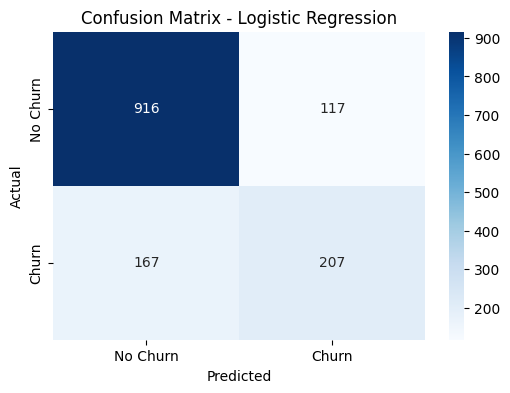

In [10]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

log_classification_report = classification_report(y_test, y_pred)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
def plot_cm(cm):
    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['No Churn','Churn'], yticklabels=['No Churn','Churn'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix - Logistic Regression')
    plt.show()
plot_cm(cm)

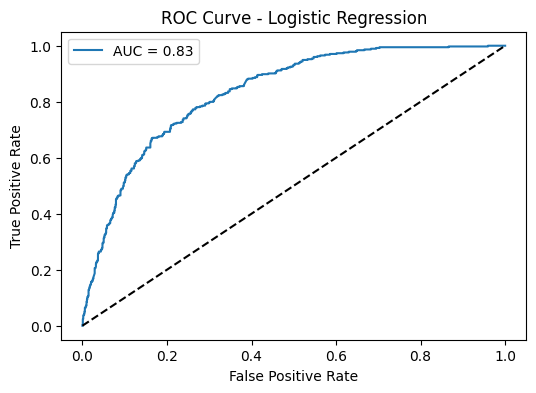

In [11]:
def plot_ROC(y_test, y_pred):
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)

    plt.figure(figsize=(6,4))
    plt.plot(fpr, tpr, label=f'AUC = {auc:.2f}')
    plt.plot([0,1],[0,1],'k--')  # random baseline
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve - Logistic Regression')
    plt.legend()
    plt.show()

plot_ROC(y_test, y_pred)

In [12]:
coefficients = pd.DataFrame({
    'Feature': X_train.columns,
    'Coefficient': lg_model.coef_[0],
    'Odds Ratio': np.exp(lg_model.coef_[0])
}
).sort_values(by = 'Odds Ratio', ascending=False)

coefficients

,Feature,Coefficient,Odds Ratio
12,InternetService_Fiber optic,0.742381,2.100933
17,PaymentMethod_Electronic check,0.401110,1.493482
9,StreamingTV,0.309858,1.363231
11,PaperlessBilling,0.298150,1.347364
10,StreamingMovies,0.289795,1.336153
4,MultipleLines,0.272243,1.312906
0,SeniorCitizen,0.213280,1.237731
18,PaymentMethod_Mailed check,0.112382,1.118941
7,DeviceProtection,0.055533,1.057104
16,PaymentMethod_Credit card (automatic),0.046810,1.047923


* Positive Coef / odds ratio > 1 --> Increases churn risk
* Negative Coef / odds ratio < 1 --> Decreases churn risk

##### **Logisitc Model Summary**
**1. Overall Performance**
* Accuracy: ~80% → the model correctly predicts 8 out of 10 customers.

* ROC AUC: ~0.83 → decent ability to separate churners from non-churners (better than random guessing, which would be 0.5).

**2. By Class**
* Class 0 (No Churn)
    * Precision: 0.85 → when the model predicts “no churn,” it’s correct 85% of the time.

    * Recall: 0.89 → it catches 89% of actual “no churn” customers.

    * F1: 0.87 → strong balance between precision and recall.

* Class 1 (Churn)

    * Precision: 0.64 → when the model predicts “churn,” it’s correct 64% of the time.

    * Recall: 0.55 → it only identifies 55% of actual churners (misses almost half).

    * F1: 0.59 → weaker performance on churn compared to no-churn.

This imbalance is likely because churn is the minority class

**3. Confusion Matirx Interpretation**
* True Negatives (TN): 916 → correctly predicted non-churners.

* False Positives (FP): 117 → predicted churn but customer stayed.

* False Negatives (FN): 167 → predicted stay but customer churned (these are the most costly mistakes).

* True Positives (TP): 207 → correctly predicted churners.

**4. Buisness Takeaway**
* The model is good at spotting who will stay but struggles with churn detection.

* In business terms: if this model is used, retention campaigns will miss ~45% of the customers who actually churn. That’s risky.

* But when it does flag churn, it’s right 64% of the time, which is better than random targeting.


### **Random Forest Model**

##### **Training the RF model**

In [13]:
rf_df = model_df.drop(columns=['gender', 'customerID', 'TenureGroup'])
X = rf_df.drop(columns='Churn')
y = rf_df['Churn']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size= 0.2,     # 20% test set
    random_state=42,    # reproducibility
    stratify = y        # keeps churn ration balanced
)

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators= 200,          # Number of Trees
    max_depth=None,             # let trees grow until leaves are pure
    class_weight='balanced',    # Handle class imbalance
    random_state=42
)

rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

Accuracy: 0.7810945273631841
ROC AUC: 0.8334765570401353

Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.61      0.48      0.54       374

    accuracy                           0.78      1407
   macro avg       0.72      0.69      0.70      1407
weighted avg       0.77      0.78      0.77      1407



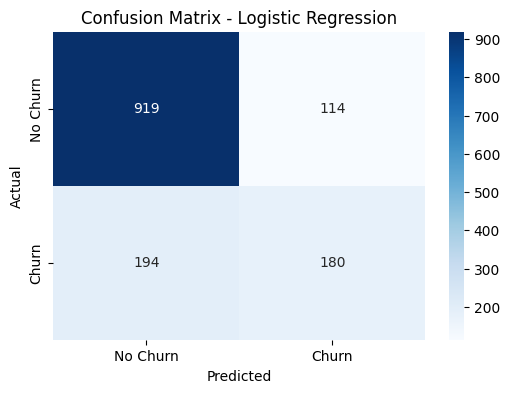

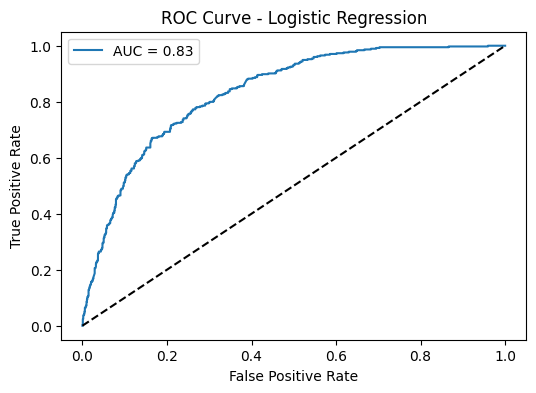

In [15]:
rf_classification_report = classification_report(y_test, y_pred)

print('Accuracy:', accuracy_score(y_test, y_pred))
print('ROC AUC:', roc_auc_score(y_test, y_prob))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plot_cm(cm)
plot_ROC(y_test, y_pred)

##### **Feature Importance**

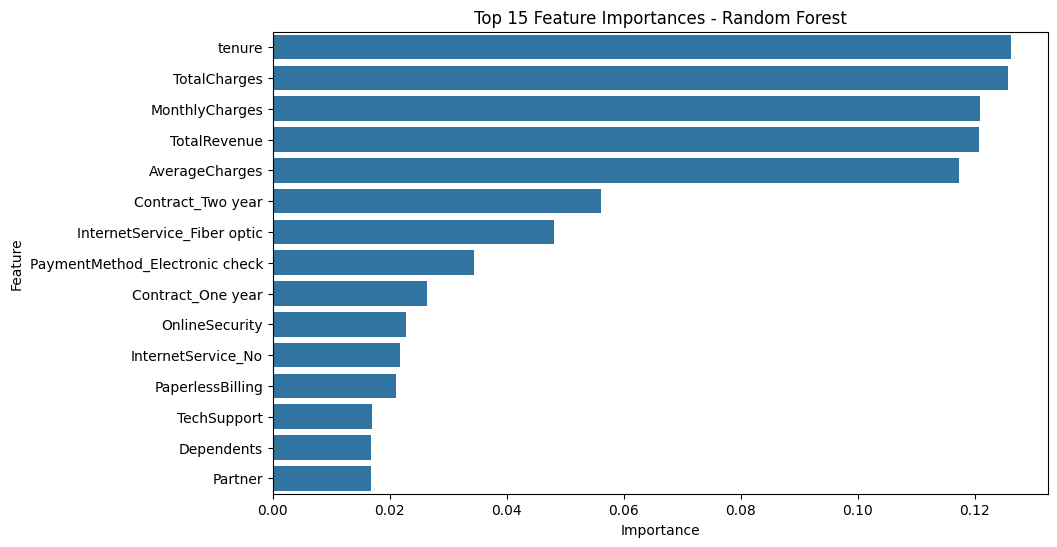

In [16]:
# Get feature importances
importances = rf.feature_importances_
features = X_train.columns

# Put into a DataFrame for easy handling
feat_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=feat_importance_df.head(15))
plt.title("Top 15 Feature Importances - Random Forest")
plt.show()

* The results are worse than the Logistic Regression Model.

### **XGBoost Model**

In [17]:
from xgboost import XGBClassifier

In [18]:
xgb = XGBClassifier(
    random_state = 42,
    eval_metric = 'logloss',
    use_label_encoder = False,
    n_estimators = 200,
    learning_rate = 0.05,
    max_depth = 4,
    subsample = 0.8,
    colsample_bytree = 0.8
)

xgb.fit(X_train, y_train)

c:\Users\djhic\Downloads\VS Code Projects\.venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [16:27:29] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [19]:
y_pred = xgb.predict(X_test)

y_proba = xgb.predict_proba(X_test)[:,1]

In [20]:
xgb_classification_report = classification_report(y_test, y_pred)

print("Accuracy:", xgb.score(X_test, y_test))
print("ROC AUC:", roc_auc_score(y_test, y_proba))    
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.7931769722814499
ROC AUC: 0.8354165480325721

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.63      0.53      0.58       374

    accuracy                           0.79      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.78      0.79      0.79      1407



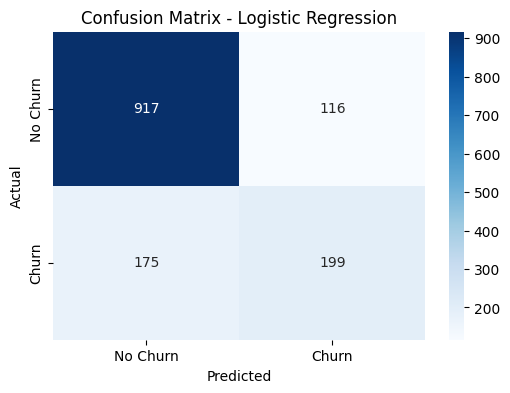

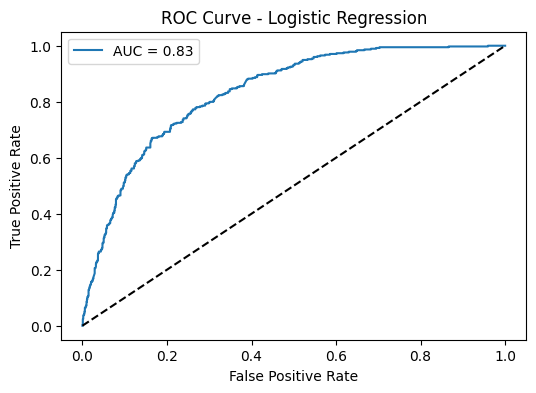

In [21]:
cm = confusion_matrix(y_test, y_pred)
plot_cm(cm)
plot_ROC(y_test, y_pred)

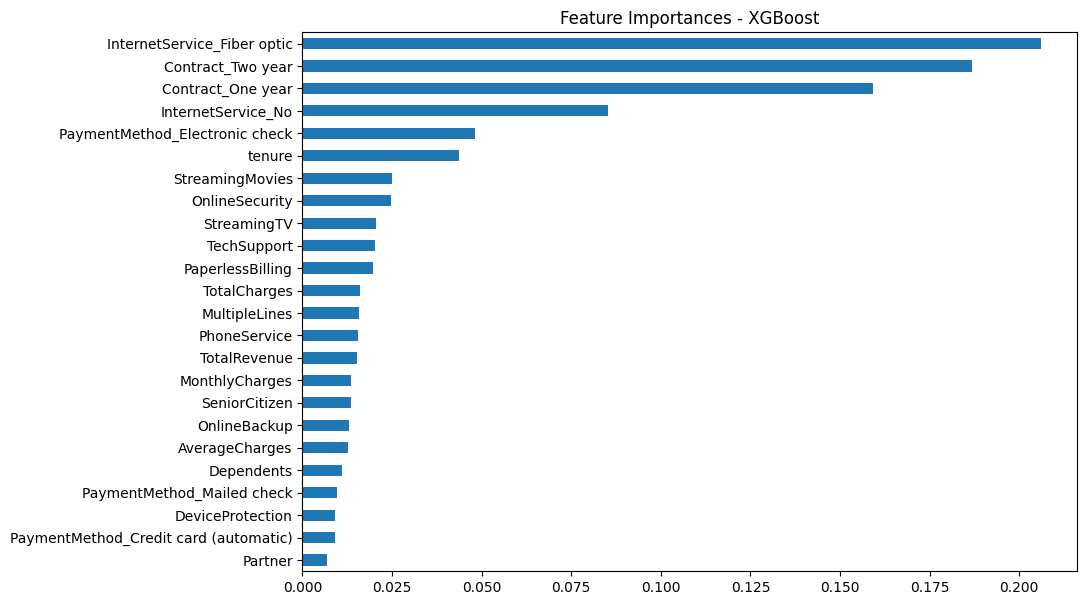

In [22]:
importances = pd.Series(xgb.feature_importances_, index=X_train.columns)
importances.sort_values(ascending=True).plot.barh(figsize=(10,7))
plt.title("Feature Importances - XGBoost")
plt.show()

In [28]:
print("Logistic Regression: \n", log_classification_report)
print("Random Forest \n", rf_classification_report)
print("XGBoost: \n", xgb_classification_report)

Logistic Regression: 
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.64      0.55      0.59       374

    accuracy                           0.80      1407
   macro avg       0.74      0.72      0.73      1407
weighted avg       0.79      0.80      0.79      1407

Random Forest 
               precision    recall  f1-score   support

           0       0.83      0.89      0.86      1033
           1       0.61      0.48      0.54       374

    accuracy                           0.78      1407
   macro avg       0.72      0.69      0.70      1407
weighted avg       0.77      0.78      0.77      1407

XGBoost: 
               precision    recall  f1-score   support

           0       0.84      0.89      0.86      1033
           1       0.63      0.53      0.58       374

    accuracy                           0.79      1407
   macro avg       0.74      0.71      0.72      1407
weighted avg       0.78 

* Logistic Regression still is the best for the dataset

### **Revising Logistic Model**

* Decided to move forward with Logistic Regression because it provided the best results
* The goal here is to improve the recall and precision of customers that churn 
* We are okay with more false positives because we would rather over predict the amount of churners than under predict it

In [34]:
from sklearn.metrics import precision_recall_curve
# Scaling Continuous Variables
y = model_df['Churn']
X = df_vif

scaler = StandardScaler()
X['tenure'] = scaler.fit_transform(X[['tenure']])

# Spliting the Data into training and test
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size= 0.2,     # 20% test set
    random_state=42,    # reproducibility
    stratify = y        # keeps churn ration balanced
)

In [92]:
lg_model = LogisticRegression(max_iter= 1000, 
                              random_state= 42,
                              class_weight= 'balanced') # Setting class weight to 'balanced' penalizes misclassifying churners more heavily.
lg_model.fit(X_train, y_train)

y_pred = lg_model.predict(X_test)

y_prob = lg_model.predict_proba(X_test)[:, 1]



In [93]:
y_pred_thresh = (y_prob >= 0.45).astype(int)

In [94]:
print("New: \n", classification_report(y_test, y_pred_thresh))
print('Old: \n', log_classification_report)

New: 
               precision    recall  f1-score   support

           0       0.91      0.67      0.78      1033
           1       0.48      0.82      0.60       374

    accuracy                           0.71      1407
   macro avg       0.69      0.75      0.69      1407
weighted avg       0.80      0.71      0.73      1407

Old: 
               precision    recall  f1-score   support

           0       0.85      0.89      0.87      1033
           1       0.64      0.55      0.59       374

    accuracy                           0.80      1407
   macro avg       0.74      0.72      0.73      1407
weighted avg       0.79      0.80      0.79      1407



### **Model Summary**

We tested three different models — Logistic Regression, Random Forest, and XGBoost — to predict customer churn.

* Logistic Regression emerged as the most effective baseline model. It achieved an accuracy of ~80% and a ROC AUC of 0.83, indicating strong discriminatory power between churners and non-churners. Importantly, it is also the most interpretable model, which allows us to clearly explain the impact of features such as tenure, contract type, internet service, and payment method on churn risk.

* Random Forest and XGBoost performed competitively, with accuracies around 78–79% and similar ROC AUC values. However, they did not significantly outperform Logistic Regression on this dataset. Their main contribution was providing additional validation that the same set of features drive churn consistently across different model types.

* Recognizing that predicting churners (class 1) is the key business goal, we implemented class weighting and threshold adjustment in Logistic Regression. This increased recall for churners from 0.55 → 0.82, meaning the model now successfully identifies the majority of at-risk customers. The tradeoff is a reduction in precision (0.64 → 0.48), which means more false positives, but this is often acceptable in a churn prevention context where missing churners is more costly than over-targeting.

**Final Takeaway:**

Logistic Regression, with adjusted thresholds and class balancing, provides the best balance of predictive power and business interpretability. It allows the company to identify over 80% of potential churners, giving marketing and customer success teams a valuable tool for proactive retention efforts.
